In [2]:
"""
Skin cancer lesion classification using the HAM10000 dataset

Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description: 
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_df = pd.read_csv('HAM10000/HAM10000_metadata.csv')
print(skin_df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


In [3]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [4]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

C:\Users\haide\AppData\Local\Temp\ipykernel_10308\3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


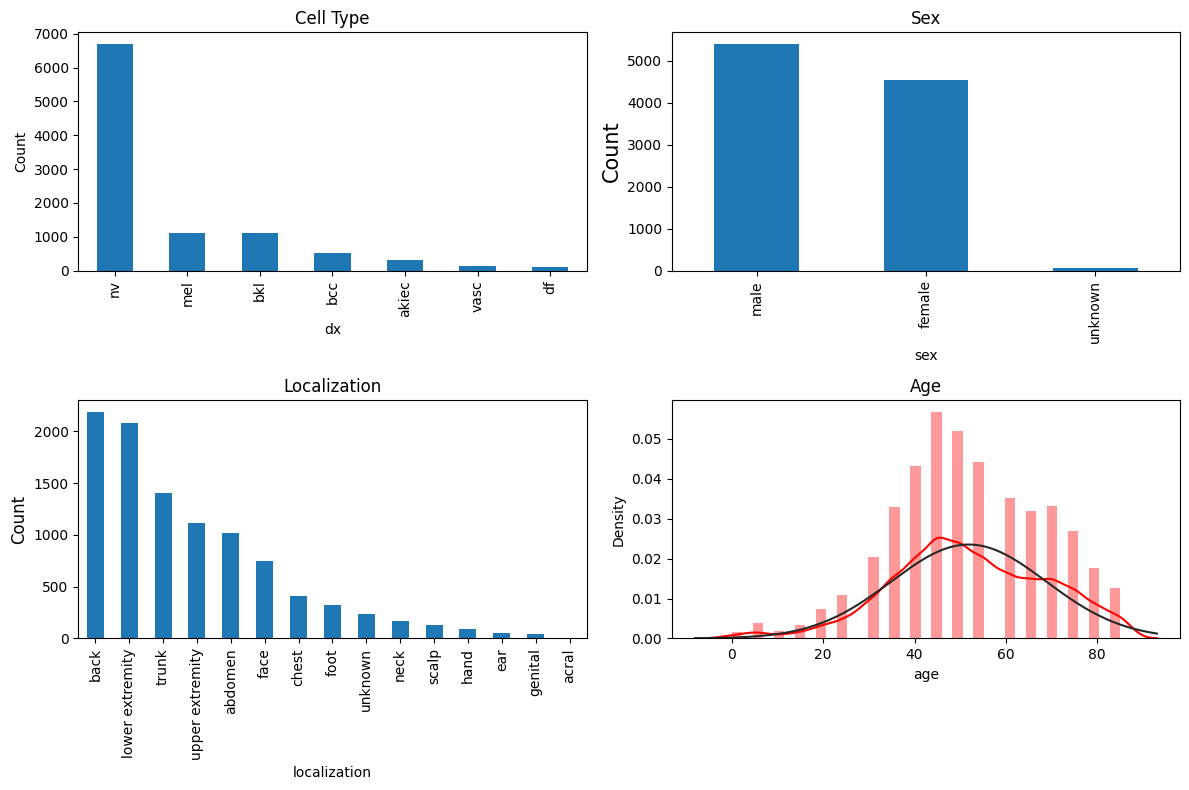

In [5]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [6]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [7]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [8]:
n_samples=6500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [9]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [10]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    6500
1    6500
2    6500
3    6500
4    6500
5    6500
6    6500
Name: count, dtype: int64


In [11]:
import os
from glob import glob

# Safely collect all image paths from both subfolders
image_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join('HAM10000', 'HAM10000_images_part_*', '*.jpg'))
}

# Map the collected paths to the dataframe using image_id
skin_df['path'] = skin_df['image_id'].map(image_path)


In [12]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

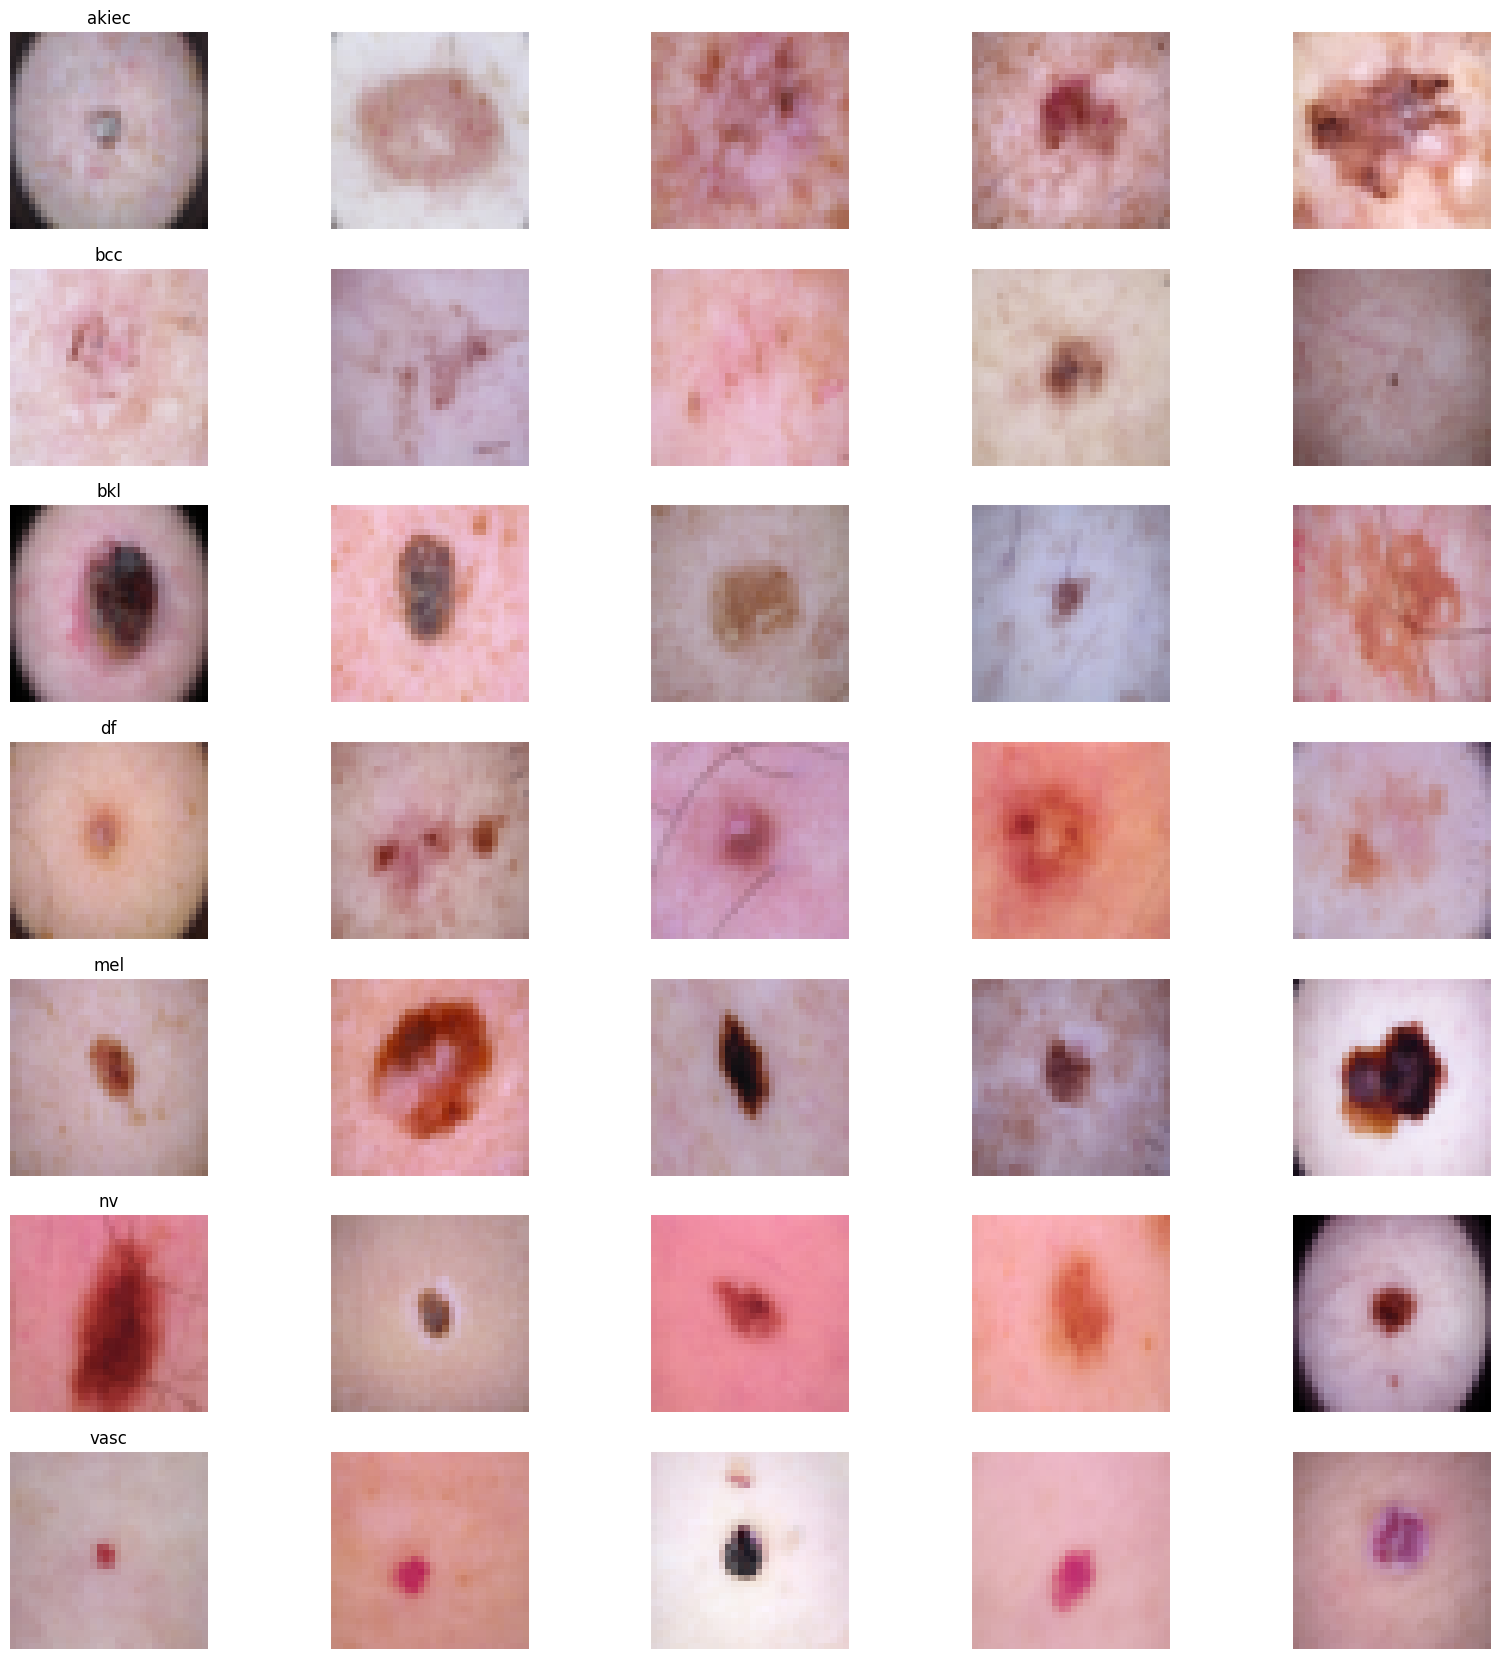

In [13]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [14]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [15]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

c:\Users\haide\anaconda3\envs\sd_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 20

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])
# 💾 Save the model
model.save('models/final_skin_cancer_model.h5')
print("Model saved to 'models/final_skin_cancer_model.h5'")

Epoch 1/20
2133/2133 - 285s - 134ms/step - acc: 0.4270 - loss: 1.4235 - val_acc: 0.5520 - val_loss: 1.1793
Epoch 2/20
2133/2133 - 453s - 212ms/step - acc: 0.5575 - loss: 1.1335 - val_acc: 0.6491 - val_loss: 0.9661
Epoch 3/20
2133/2133 - 441s - 207ms/step - acc: 0.6230 - loss: 0.9854 - val_acc: 0.7090 - val_loss: 0.7899
Epoch 4/20
2133/2133 - 387s - 182ms/step - acc: 0.6582 - loss: 0.8876 - val_acc: 0.7153 - val_loss: 0.7581
Epoch 5/20
2133/2133 - 221s - 104ms/step - acc: 0.6898 - loss: 0.8198 - val_acc: 0.7814 - val_loss: 0.6284
Epoch 6/20
2133/2133 - 216s - 101ms/step - acc: 0.7065 - loss: 0.7649 - val_acc: 0.8102 - val_loss: 0.5665
Epoch 7/20
2133/2133 - 216s - 101ms/step - acc: 0.7288 - loss: 0.7166 - val_acc: 0.8072 - val_loss: 0.5266
Epoch 8/20
2133/2133 - 269s - 126ms/step - acc: 0.7403 - loss: 0.6891 - val_acc: 0.8100 - val_loss: 0.5381
Epoch 9/20
2133/2133 - 223s - 104ms/step - acc: 0.7504 - loss: 0.6579 - val_acc: 0.8173 - val_loss: 0.4892
Epoch 10/20
2133/2133 - 222s - 104ms/

Test accuracy: 0.9004834890365601
Model saved to 'models/final_skin_cancer_model.h5'


In [17]:
model

<Sequential name=sequential, built=True>

In [ ]:
mx2i824y51r5w04636f4i616fl4ddx50

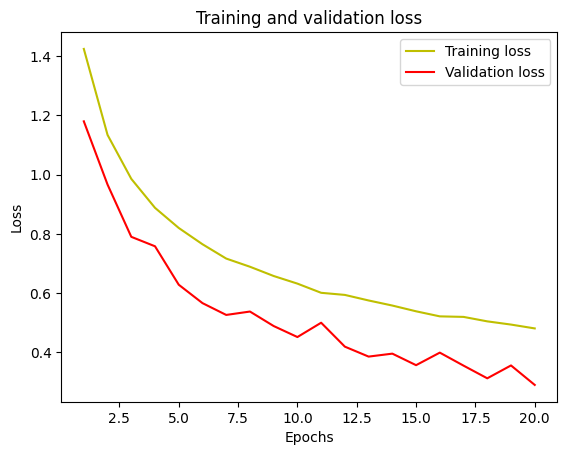

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

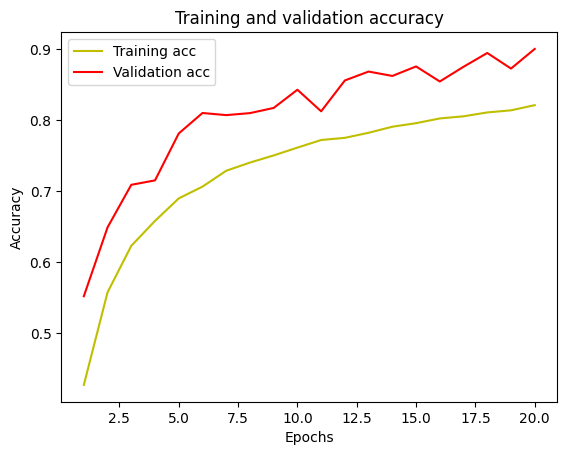

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [20]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step


<Axes: >

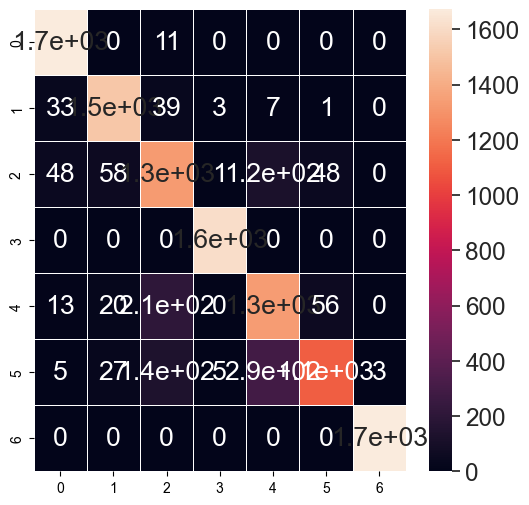

In [21]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

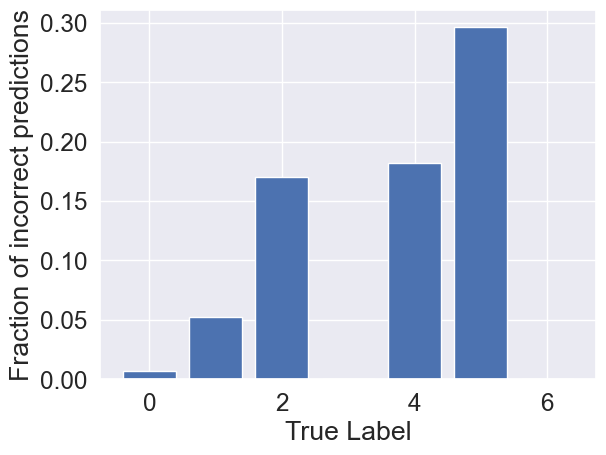

In [22]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [23]:
model.save('final_model.h5')

In [36]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

def predict_skin_cancer(image_path, model_path='models/final_skin_cancer_model.h5', size=(32, 32), confidence_threshold=0.7):
    """
    Predicts the skin cancer type from a JPG image with a 'no cancer' conclusion for low-confidence predictions.
    
    Args:
        image_path (str): Path to the JPG image file
        model_path (str): Path to the saved model (default: 'models/final_skin_cancer_model.h5')
        size (tuple): Size to resize the image to (default: (32, 32))
        confidence_threshold (float): Minimum confidence score to consider a prediction valid (default: 0.7)
        
    Returns:
        dict: A dictionary containing the predicted class, confidence scores, and a flag for low confidence
    """
    # Class names matching HAM10000 dx abbreviations
    class_names = {
        0: 'akiec',    # Actinic keratoses
        1: 'bcc',      # Basal cell carcinoma
        2: 'bkl',      # Benign keratosis-like lesions
        3: 'df',       # Dermatofibroma
        4: 'mel',      # Melanoma
        5: 'nv',       # Melanocytic nevi (benign)
        6: 'vasc'      # Vascular lesions
    }
    
    # Benign classes (non-cancerous)
    benign_classes = ['bkl', 'df', 'nv', 'vasc']
    
    try:
        # Load the model
        model = load_model(model_path)
        
        # Load and preprocess the image
        img = Image.open(image_path)
        
        # Convert grayscale to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        img = img.resize(size)
        img_array = np.asarray(img)
        
        # Normalize and add batch dimension
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Rebuild model metrics
        model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
        
        # Make prediction
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = np.max(predictions[0])
        
        # Get confidence scores for all classes
        confidence_scores = {
            class_names[i]: float(predictions[0][i]) for i in range(len(class_names))
        }
        
        # Determine if prediction is low confidence
        low_confidence = confidence < confidence_threshold
        
        # Determine conclusion
        if low_confidence:
            conclusion = "No confident cancer prediction (all probabilities < {:.0%})".format(confidence_threshold)
        elif predicted_class in benign_classes:
            conclusion = "Benign lesion detected"
        else:
            conclusion = "Potential malignancy detected"
        
        return {
            'predicted_class': predicted_class,
            'confidence': float(confidence),
            'all_predictions': confidence_scores,
            'conclusion': conclusion,
            'low_confidence': low_confidence,
            'is_benign': predicted_class in benign_classes
        }
        
    except Exception as e:
        return {
            'error': str(e),
            'details': 'Please check the input image and model compatibility.'
        }

In [37]:
# Example usage
result = predict_skin_cancer('C:/Users/haide/Downloads/meri_image.jpg')
print("result: ",result)
print(f"Predicted Cancer Type: {result['predicted_class']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nAll predictions:")
for class_name, score in result['all_predictions'].items():
    print(f"{class_name}: {score:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
result:  {'predicted_class': 'mel', 'confidence': 0.42988136410713196, 'all_predictions': {'akiec': 3.3990346537393634e-08, 'bcc': 2.62076409853762e-05, 'bkl': 0.14923369884490967, 'df': 2.0709252368522613e-10, 'mel': 0.42988136410713196, 'nv': 0.4208585023880005, 'vasc': 1.0318991172653114e-07}, 'conclusion': 'No confident cancer prediction (all probabilities < 70%)', 'low_confidence': np.True_, 'is_benign': False}
Predicted Cancer Type: mel
Confidence: 42.99%

All predictions:
akiec: 0.00%
bcc: 0.00%
bkl: 14.92%
df: 0.00%
mel: 42.99%
nv: 42.09%
vasc: 0.00%


In [35]:
import os
import random
import pandas as pd
from glob import glob

# Load metadata
metadata_path = 'HAM10000/HAM10000_metadata.csv'
metadata = pd.read_csv(metadata_path)

# Create dictionary for quick lookup {image_id: dx_label}
label_dict = dict(zip(metadata['image_id'], metadata['dx']))

# Get all JPG files from the directory
image_dir = 'HAM10000/HAM10000_images_part_1'
all_images = glob(os.path.join(image_dir, '*.jpg'))

# Randomly select 10 images
random.seed(42)  # For reproducibility
selected_images = random.sample(all_images, 10)

# Process each image
for i, img_path in enumerate(selected_images, 1):
    print(f"\n{'='*50}")
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    print(f"Image {i}: {image_id}")
    print(f"{'='*50}")
    
    # Get ground truth
    true_label = label_dict.get(image_id, "UNKNOWN")
    
    result = predict_skin_cancer(img_path)
    
    if 'error' in result:
        print(f"Error processing image: {result['error']}")
        continue
    
    print(f"Predicted Class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Ground Truth: {true_label}")
    
    # Check if prediction matches ground truth
    is_correct = (result['predicted_class'].lower() == true_label.lower())
    print(f"Correct: {'✅' if is_correct else '❌'}")
    
    # Print top 3 predictions
    sorted_predictions = sorted(result['all_predictions'].items(), 
                             key=lambda x: x[1], reverse=True)
    print("\nTop 3 Predictions:")
    for class_name, score in sorted_predictions[:3]:
        print(f"- {class_name}: {score:.2%}")


Image 1: ISIC_0025218


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Predicted Class: nv
Confidence: 82.09%
Ground Truth: nv
Correct: ✅

Top 3 Predictions:
- nv: 82.09%
- bkl: 12.46%
- mel: 5.35%

Image 2: ISIC_0024510


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Predicted Class: nv
Confidence: 100.00%
Ground Truth: nv
Correct: ✅

Top 3 Predictions:
- nv: 100.00%
- bkl: 0.00%
- mel: 0.00%

Image 3: ISIC_0026559


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Predicted Class: nv
Confidence: 40.14%
Ground Truth: nv
Correct: ✅

Top 3 Predictions:
- nv: 40.14%
- mel: 28.14%
- akiec: 17.59%

Image 4: ISIC_0026312


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Predicted Class: nv
Confidence: 99.25%
Ground Truth: nv
Correct: ✅

Top 3 Predictions:
- nv: 99.25%
- mel: 0.73%
- bkl: 0.02%

Image 5: ISIC_0026134


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Predicted Class: nv
Confidence: 100.00%
Ground Truth: nv
Correct: ✅

Top 3 Predictions:
- nv: 100.00%
- bkl: 0.00%
- mel: 0.00%

Image 6: ISIC_0025449


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Predicted Class: nv
Confidence: 98.11%
Ground Truth: nv
Correct: ✅

Top 3 Predictions:
- nv: 98.11%
- mel: 0.88%
- bkl: 0.70%

Image 7: ISIC_0025145


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Predicted Class: mel
Confidence: 83.32%
Ground Truth: mel
Correct: ✅

Top 3 Predictions:
- mel: 83.32%
- nv: 12.40%
- bkl: 4.21%

Image 8: ISIC_0028773


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Predicted Class: mel
Confidence: 91.25%
Ground Truth: mel
Correct: ✅

Top 3 Predictions:
- mel: 91.25%
- nv: 8.17%
- bkl: 0.58%

Image 9: ISIC_0025018


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Predicted Class: mel
Confidence: 54.23%
Ground Truth: mel
Correct: ✅

Top 3 Predictions:
- mel: 54.23%
- nv: 42.23%
- bkl: 3.54%

Image 10: ISIC_0029143


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Predicted Class: bkl
Confidence: 52.63%
Ground Truth: nv
Correct: ❌

Top 3 Predictions:
- bkl: 52.63%
- nv: 17.23%
- bcc: 15.18%
